In [63]:
# import standard libraries
import torch
import matplotlib.pyplot as plt
import numpy as np
import time 
import pandas as pd
from torch import nn
import collections
import progressbar
from progressbar import FormatLabel, Percentage, Bar, ETA
import h5py
import os

# import custom libraries
from data_loader import DataLoader, batch
from data_viewer import plotTraj, animatePreview, animateLoc, animateTraj, smooth
import hdf5_utils as hd
from simulation import Agent, Engine, get_mean_speed, get_density


# Setup matplotlib in interaction mode and load style sheet
%matplotlib notebook
plt.style.use("plotstyle.mplstyle")

# reload changes in libraries automaticly 
%load_ext autoreload
%autoreload 2

# set the random seed for reproducability
np.random.seed(42)

# TODO parameter dict for agent and fix start position bug

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setting-Parameters" data-toc-modified-id="Setting-Parameters-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setting Parameters</a></span></li><li><span><a href="#Format-training-data-as-tensors" data-toc-modified-id="Format-training-data-as-tensors-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Format training data as tensors</a></span></li><li><span><a href="#Define-Model" data-toc-modified-id="Define-Model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Define Model</a></span></li><li><span><a href="#Train-model" data-toc-modified-id="Train-model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Train model</a></span></li><li><span><a href="#Check-on-test-set" data-toc-modified-id="Check-on-test-set-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Check on test set</a></span></li><li><span><a href="#Save/-Load-model" data-toc-modified-id="Save/-Load-model-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Save/ Load model</a></span></li><li><span><a href="#Simulation" data-toc-modified-id="Simulation-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Simulation</a></span><ul class="toc-item"><li><span><a href="#Singel-agent" data-toc-modified-id="Singel-agent-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Singel agent</a></span></li><li><span><a href="#Multi-agent" data-toc-modified-id="Multi-agent-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Multi agent</a></span></li></ul></li><li><span><a href="#Additional-functionalities" data-toc-modified-id="Additional-functionalities-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Additional functionalities</a></span><ul class="toc-item"><li><span><a href="#Perform-measurements" data-toc-modified-id="Perform-measurements-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>Perform measurements</a></span></li><li><span><a href="#Append-datasets" data-toc-modified-id="Append-datasets-8.2"><span class="toc-item-num">8.2&nbsp;&nbsp;</span>Append datasets</a></span></li></ul></li></ul></div>

In this Notebook the whole wokflow of training and testing a network is shown. In the data folder some Models that are pretrained can be found. If you do not want to train a network you may skip the step 4-5. But keep in minde to initalize the parameter dict and load the dataset even if you load an existing model. 

# Setting Parameters

First we define the parameters for the model and dataset preprocessing. 

In [2]:
# give each dataset a unique index so we can perform scans
scan = {"ug-180-015":0,
        "ug-180-030":1,
        "ug-180-060":2,
        "ug-180-085":3,
        "ug-180-095":4,
        "ug-180-110":5,
        "ug-180-140":6,
        "ug-180-230":7,
       }

# allow the loading of existing HDF 5 for the exact same parameters 
# if it is false the trajecories are extracted every time which is slower
load_traindata = True

# Set here the parameters for the I/O of the model
dset = {'neighbors':6,
        'ret_vel':True,
        'nn_vel': True,
        'truth_with_vel': True,
        'shuffle':True,
        'mode': "wrap",
        'step_nr':1,
        'downsample':8,
        'fps':16,
        'name':  "ug-180-015"  #"ao-360-400_combine"
       }
# availiabel person for a width of 180: 15, 30, 60, 85, 95 110, 140, 230

# Set the parametes for the model and the hyperparameters
param = {'input_s': 2+2*dset['ret_vel']  + dset['neighbors']*(2+2*dset['nn_vel']), #(number_nei+1)*4,
         'hidden_s': [32, 32, 64, 128, 128, 40],# EPFL trafic network
         'output_s': 2+dset['truth_with_vel']*2,
         'epochs':15,
         'batch_size':10,
         'lr':1e-3,
         'decay':0.1,
         'decay_step':5,
         #'dtype':torch.float,
         'device':torch.device("cuda:0"),
         'dataset':dset,
        }



# Path to datasets
#PATH = "../../other/AO/"
PATH = "../../other/UG/UG-roh_nachkorrigiert/"

#Paht where existing trainig data is stored
PATH2 = "data/HD5/"


Now we can load a dataset from the given path. We want to get the training, validatan and testing data. The first time for a given dataset and parameters we extract all trajectories and convert them to the training input/truth pairs. In order to save time we store the created splits as a HDF5 file. If the same dataset was already used with the same settings we load it directly from the HDF5 File, which is faster.

In [3]:

ds = DataLoader(PATH + dset['name'] + ".txt")

ds.load()

print("Persons: ", ds.data.p.max())
print("Frame maximum :", ds.data.f.max() )

# generate filename encoding the parameters
sufix = "_nn{}_s{}_vr{}_m{}_vi{}_st{}_d{}".format(dset['neighbors'],
                                 dset['shuffle'],
                                 dset['truth_with_vel'],
                                 dset['mode'],
                                 dset['ret_vel']+dset['nn_vel'], 
                                 dset['step_nr'],
                                 dset['downsample'])

# generate filenmae at export direcotry
f_name = PATH2+param['dataset']['name']+sufix+'.h5'

# if file exsists we load it tor reduce computation time
if os.path.isfile(f_name) and load_traindata:

    train, val, test, param['dataset'] = hd.load_trainingdata(f_name)
    scan_idx = scan[param['dataset']['name']]
    print("Trainingdata has been loaded")
    
else: # we never used the dataset with the given parameters or we want to recompute the trajectories
    # here we could select data augmentation to get more training samples 
    f_x = ds.flip_x
    augmentation = []# [f_x]
    
    # use the functionality of the dataloader to get the train/test split
    train, val, test = ds.get_train_data(dset['neighbors'], 
                                         step_nr=dset['step_nr'],
                                         downsample=dset['downsample'],
                                         augmentation=augmentation,
                                         ret_vel=dset['ret_vel'],
                                         nn_vel=dset['nn_vel'],
                                         shuffle=dset['shuffle'],
                                         truth_with_vel=dset['truth_with_vel'],
                                         mode=dset['mode'])
    # Fill the rest of the parameters
    dset['date'] = time.ctime()
    dset['creator'] = 'zehndiii'
    dset['augmentation'] = str(augmentation)
    param['dataset'] = dset
    
    # save the training data in the output folder
    hd.save_trainingdata(f_name, param, train, val, test)
    scan_idx = scan[param['dataset']['name']]
    print("Training data saved to : {}".format(PATH2+f_name+sufix+'.h5'))

loaded 54 persons
Persons:  54
Frame maximum : 1643
Trainingdata has been loaded


In [4]:
# check the parameter of a given file and its dimentions. 
hd.print_stats(PATH2+param['dataset']['name']+sufix+'.h5')

File: data/HD5/ug-180-015_nn6_sTrue_vrTrue_mwrap_vi2_st1_d8.h5/
|     Size: 1.06MB
|     @augmentation: []
|     @creator: zehndiii
|     @date: Wed Nov 25 18:35:01 2020
|     @downsample: 8
|     @fps: 16
|     @mode: wrap
|     @name: ug-180-015
|     @neighbors: 6
|     @nn_vel: True
|     @ret_vel: True
|     @shuffle: True
|     @step_nr: 1
|     @truth_with_vel: True
|
|Group: test 
|     |-----Dataset: input           - Shape: (1745, 28) float32
|     |-----Dataset: truth           - Shape: (1745, 4) float32
|
|Group: train 
|     |-----Dataset: input           - Shape: (5235, 28) float32
|     |-----Dataset: truth           - Shape: (5235, 4) float32
|
|Group: val 
|     |-----Dataset: input           - Shape: (1746, 28) float32
|     |-----Dataset: truth           - Shape: (1746, 4) float32


# Format training data as tensors

In order to use the data with PyTorch we need to transform the data to a pytorch tensor. We send the tensors to an Nvidia GPU if available. 

In [5]:


t_input, t_truth = train
v_input, v_truth = val
test_input, test_truth = test


if param['dataset']['name']=='all':
    p = np.random.permutation(len(t_truth))
    #np.random.shuffle(steps_input)
    print("extra shuffeling")
    t_input = t_input[p]
    t_truth = t_truth[p]
    

t_i = torch.from_numpy(t_input).to(param['device'])
t_t = torch.from_numpy(t_truth).to(param['device'])

v_i = torch.from_numpy(v_input).to(param['device'])
v_t = torch.from_numpy(v_truth).to(param['device'])

test_i = torch.from_numpy(test_input).to(param['device'])
test_t = torch.from_numpy(test_truth).to(param['device'])




# Define Model

We define the model architecture as a class which is derived from the torch.nn.Module class. We pass the network size as parametrs which allows us to switch easily between different architectures.

In [6]:


# Fully connected neural network with five hidden layer
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNet, self).__init__()
        self.fc_in = nn.Linear(input_size, hidden_size[0]) 
        
        #self.fc_hidden = []
        #for i in range(len(hidden_size)-1):
        self.fc_hidden_1 = nn.Linear(hidden_size[0], hidden_size[1])
        self.fc_hidden_2 = nn.Linear(hidden_size[1], hidden_size[2])
        self.fc_hidden_3 = nn.Linear(hidden_size[2], hidden_size[3])
        
        self.fc_hidden_4 = nn.Linear(hidden_size[3], hidden_size[4])
        self.fc_hidden_5 = nn.Linear(hidden_size[4], hidden_size[5])

        
        self.fc_out = nn.Linear(hidden_size[-1], output_size)
        self.relu = nn.ReLU()
        
    
    def forward(self, x):
     
        out = self.relu(self.fc_in(x))
        
        #for i in range(len(self.fc_hidden)):
        #    out = self.relu(self.fc_hidden[i](out))
        
        out = self.relu(self.fc_hidden_1(out))
        out = self.relu(self.fc_hidden_2(out))
        out = self.relu(self.fc_hidden_3(out))
        out = self.relu(self.fc_hidden_4(out))        
        out = self.relu(self.fc_hidden_5(out))

        
        out = self.fc_out(out)
        return out

# we create an instance of the model and send it to the specified device eg GPU or CPU
model = NeuralNet(param['input_s'], param['hidden_s'], param['output_s']).to(param['device'])


Now we define the loss function, optimizer and a learning rate scheduler. The lr scheduler allows us to reduce the learning rate over the training epochs so we can start with a bigger lr and still find a good minima in the end. 

In [7]:

loss_fn = nn.MSELoss(reduction='mean')

optimizer = torch.optim.Adam(model.parameters(), lr=param['lr'])

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=param['decay_step'], gamma=param['decay'])


# Train model

Now we can start the training loop. We shuffle the training data in every epoch than we pass the data in baches through the netork an do an optimization after every batch. At the end of an epoch we compute the loss on the validation set in order to verify that the network is learning and not overfitting.

In [8]:

d_len = t_i.shape[0]

# initialize a progressbar
pbar = progressbar.ProgressBar(max_value=param['epochs'])
widgets = [FormatLabel(''), ' ', Percentage(), ' ', Bar(), ' ', ETA()]
pbar = progressbar.ProgressBar(widgets=widgets, maxval=param['epochs']*d_len)
pbar.start()

# initialize array to keep loss
training_loss = []
validation_loss = [np.inf] # wee need a first value for the progress bar

for t in range(param['epochs']):
    
    # shuffle data
    p = np.random.permutation(len(t_i))
    t_i = t_i[p]
    t_t = t_t[p]
    
    # iterate over all batches
    for  y, (t_i_b, t_t_b) in  enumerate(batch(t_i, t_t, param['batch_size'])):
        y_pred = model(t_i_b)           # run the forward pass through the model
       
        loss = loss_fn(y_pred, t_t_b)   # compute the loss

        model.zero_grad()               # reset grads
       
        loss.backward()                 # compute correction

        optimizer.step()                # do an optimizer run
        
        # update pbar
        widgets[0] = FormatLabel('loss(t/v) : {:.4} / {:.4} | lr={:.4}'.format(loss.item(),
                                                                            validation_loss[-1],
                                                                            optimizer.param_groups[0]['lr']))
        pbar.update(t*d_len+y*param['batch_size'])
        
        if y%10==9: # store train loss every 10 batches
            training_loss += [loss.cpu().detach().numpy()]
    
    # Test on validation
    loss = []
    with torch.no_grad():
        for v_i_b, v_t_b in batch(v_i, v_t, param['batch_size']):
            y_pred = model(v_i_b)
            loss += [loss_fn(y_pred, v_t_b).cpu().detach().numpy()]
            pbar.update()
    validation_loss.append( np.array(loss).mean() )
    
    scheduler.step()
        

pbar.finish()




loss(t/v) : 141.7 / 171.0 | lr=1e-05 100% |####################| Time:  0:00:38


<IPython.core.display.Javascript object>


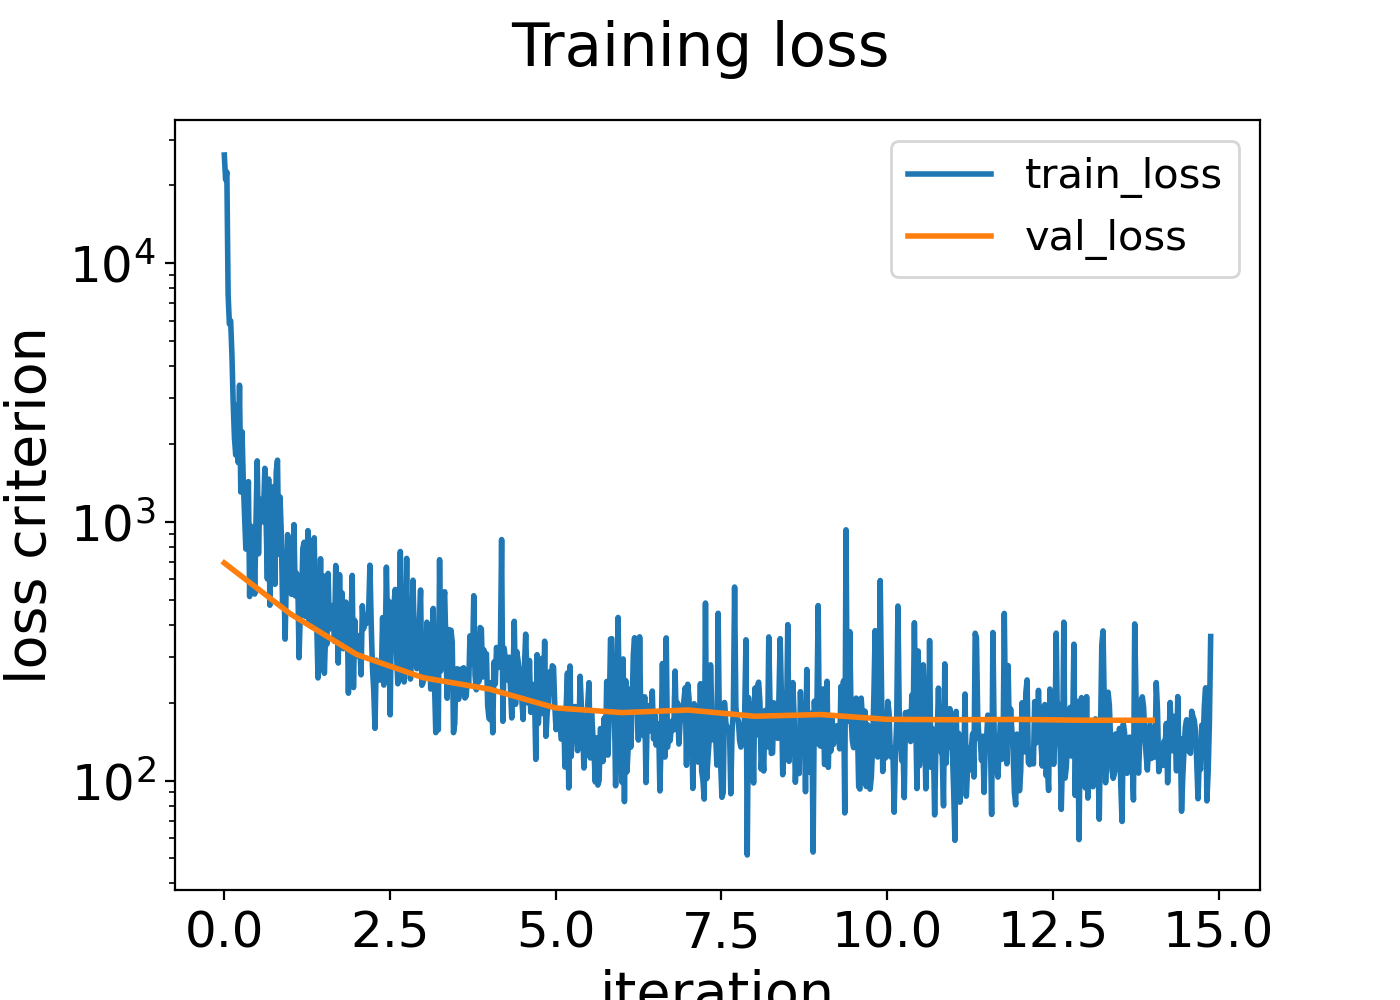

15
780


In [9]:
# convert to np arrays
train_loss = np.array(training_loss)
val_loss = np.array(validation_loss[1:])

plt.figure()
plt.semilogy(np.arange(len(train_loss))*10*param['batch_size']/d_len, train_loss, label="train_loss")
plt.semilogy(np.arange(len(val_loss)), val_loss, label="val_loss" )
plt.xlabel("iteration")
plt.ylabel("loss criterion")
plt.suptitle("Training loss")
plt.legend()
plt.show()
print(len(val_loss))
print(len(train_loss))

In [10]:
# set the model to evaluation mode 
mod = model.eval()



# Check on test set

100% (1745 of 1745) |####################| Elapsed Time: 0:00:01 Time:  0:00:01


<IPython.core.display.Javascript object>


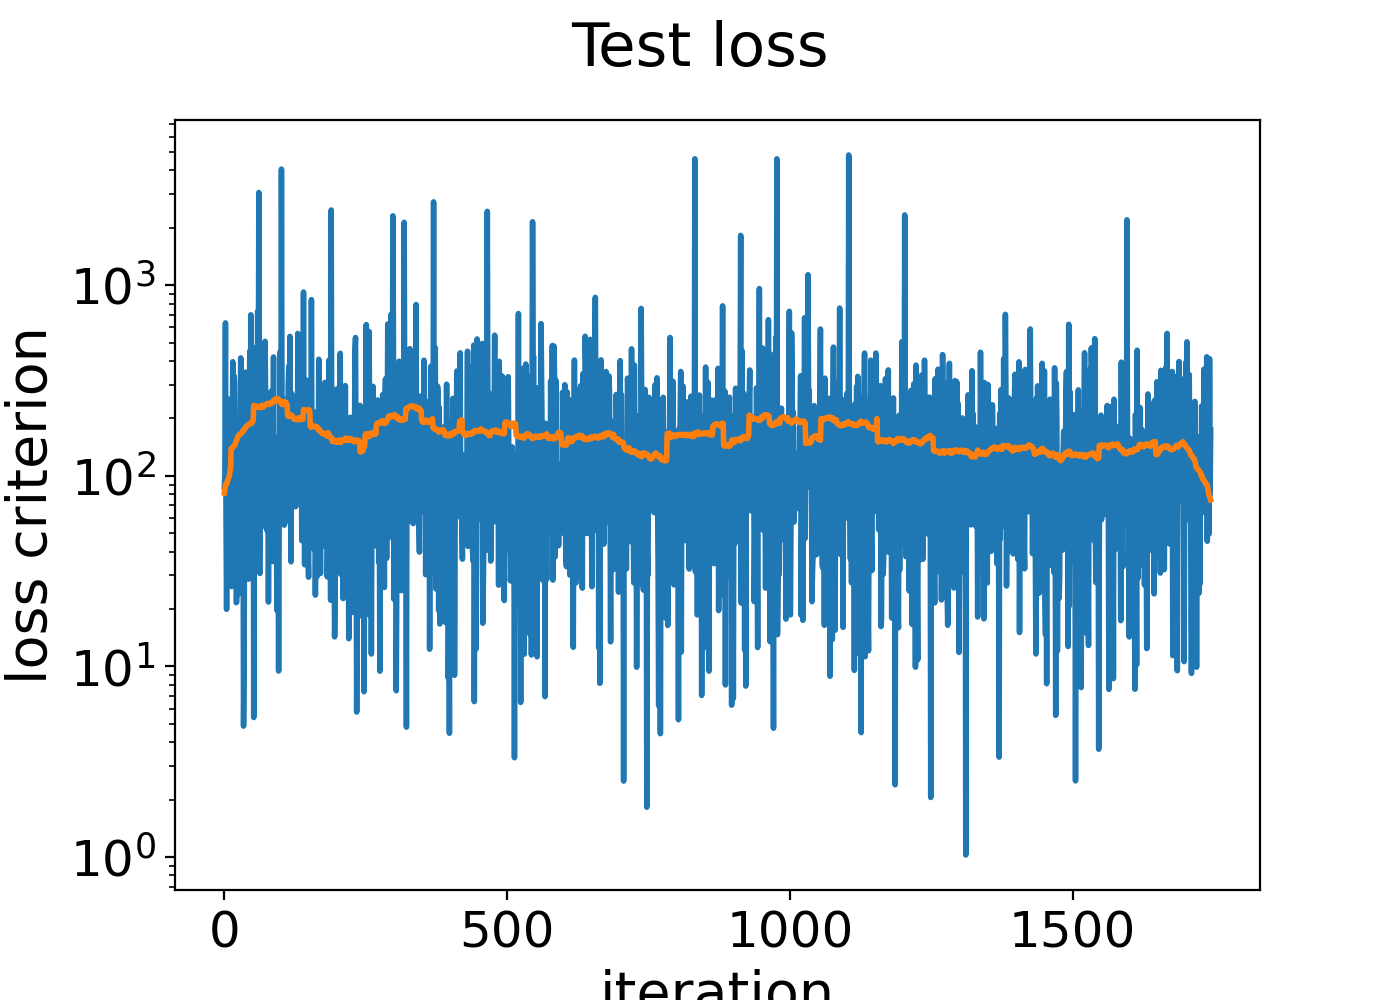

In [11]:

test_dat = []

pbar = progressbar.ProgressBar(maxval=len(test_i))
pbar.start()

i = 0

with torch.no_grad():
    for (ti, tt) in zip(test_i, test_t):
        pred = model(ti)
        loss = loss_fn(pred, tt)
        test_dat.append(loss.cpu().detach().numpy())
     
        if i%10:
            pbar.update(i)
        
        i += 1
        
    pbar.finish()
    
test_dat = np.array(test_dat)

plt.figure()
plt.semilogy(np.arange(len(test_dat)), test_dat)
plt.semilogy(np.arange(len(test_dat)), smooth(test_dat, 100))
plt.xlabel("iteration")
plt.ylabel("loss criterion")
plt.suptitle("Test loss")
plt.show()

# Save/ Load model

We create the model name with the following convention. Then we save or load the models to/from the HDF5 file. Use the msg tag to add a comment to the model.

In [12]:
PATH_M = "data/model/"
#name = "model_UG_downsample_good_"
#name = "model_phaseplott_v2_"
#name = "model_phaseplott_with_all_v2_"
name = "test_model_scan"

suffix_m = "_nn{}_vel{}{}_{}_s{}_{}_{}_e{}_lr{}".format(param['dataset']['neighbors'],
                                                         param['dataset']['ret_vel'],param['dataset']['nn_vel'],param['dataset']['truth_with_vel'],
                                                         param['input_s'],param['hidden_s'],param['output_s'],
                                                         param['epochs'],
                                                         param['lr'],
                                                        )


#f_name = PATH_M+name+"sweep_vel.h5"
f_name = PATH_M+name+suffix_m+".h5"    

f_name
type(param['input_s'])

int

In [19]:
# add here a comment to the dataset
param['msg'] = "This is a test model to show the scan functionality "

# save the model 
hd.save_torch(model, optimizer, f_name, param, prefix="model_5", scan=True)

In [18]:
# load the dataset and set mode to eval
model , param = hd.load_torch(f_name, NeuralNet, prefix="model_4")
mod = model.eval()


In [20]:
# look at the parameters from the given model
hd.print_stats(f_name)

File: data/model/test_model_scan_nn6_velTrueTrue_True_s28_[32, 32, 64, 128, 128, 40]_4_e15_lr0.001.h5/
|     Size: 912.38KB
|     @mode: multi_model
|     @models: [b'model_1' b'model_2' b'model_3' b'model_4' b'model_5']
|
|Group: model_1 
|     @batch_size: 10
|     @creator: zehndiii
|     @date: Mon Dec  7 00:58:50 2020
|     @decay: 0.1
|     @decay_step: 5
|     @device: cuda:0
|     @epochs: 15
|     @lr: 0.001
|     @mode: single_model
|     @msg: This is a test model to show the scan functionality 
|     |
|     |Group: dataset 
|     |     @augmentation: []
|     |     @creator: zehndiii
|     |     @date: Wed Nov 25 18:35:01 2020
|     |     @downsample: 8
|     |     @fps: 16
|     |     @mode: wrap
|     |     @name: ug-180-015
|     |     @neighbors: 6
|     |     @nn_vel: True
|     |     @ret_vel: True
|     |     @shuffle: True
|     |     @step_nr: 1
|     |     @truth_with_vel: True
|     |
|     |Group: model 
|     |     @hidden_s: [ 32  32  64 128 128  40]
|     | 

# Simulation 

## Singel agent

In [90]:
AGENT_OFFSET = 1000
test_person = 10

da = DataLoader(None)


da.copy(ds)

frames_o, pos_vel_o = da.person(test_person, )

da.remove_person(test_person)


agent = Agent(model,
              FPS=param['dataset']['fps']/param['dataset']['downsample'],
              pos_vel_0=pos_vel_o[0],#*[-1, 1, -1, 1],
              frame_0=int(frames_o[0]/param['dataset']['downsample'])*param['dataset']['downsample'],
              truth_with_vel=param['dataset']['truth_with_vel'],
              device=param['device'],
              id=AGENT_OFFSET+test_person )


sim = Engine(da, agents=[agent],
             stop_agent=True,
             xlim = 400, 
             param = param,
             truth=ds
            )

        
            


# run the simulation 
sim.run(1, 1000)#frames_o[-1], )

# copy simulated date 
dp = DataLoader(None)
dp.copy(sim.ds)

# save the results
do = sim.save()



sim from : 1 to 1000


Done! 100% |###################################################| Time:  0:00:01


Warning! Only new IDs are considered.


<IPython.core.display.Javascript object>


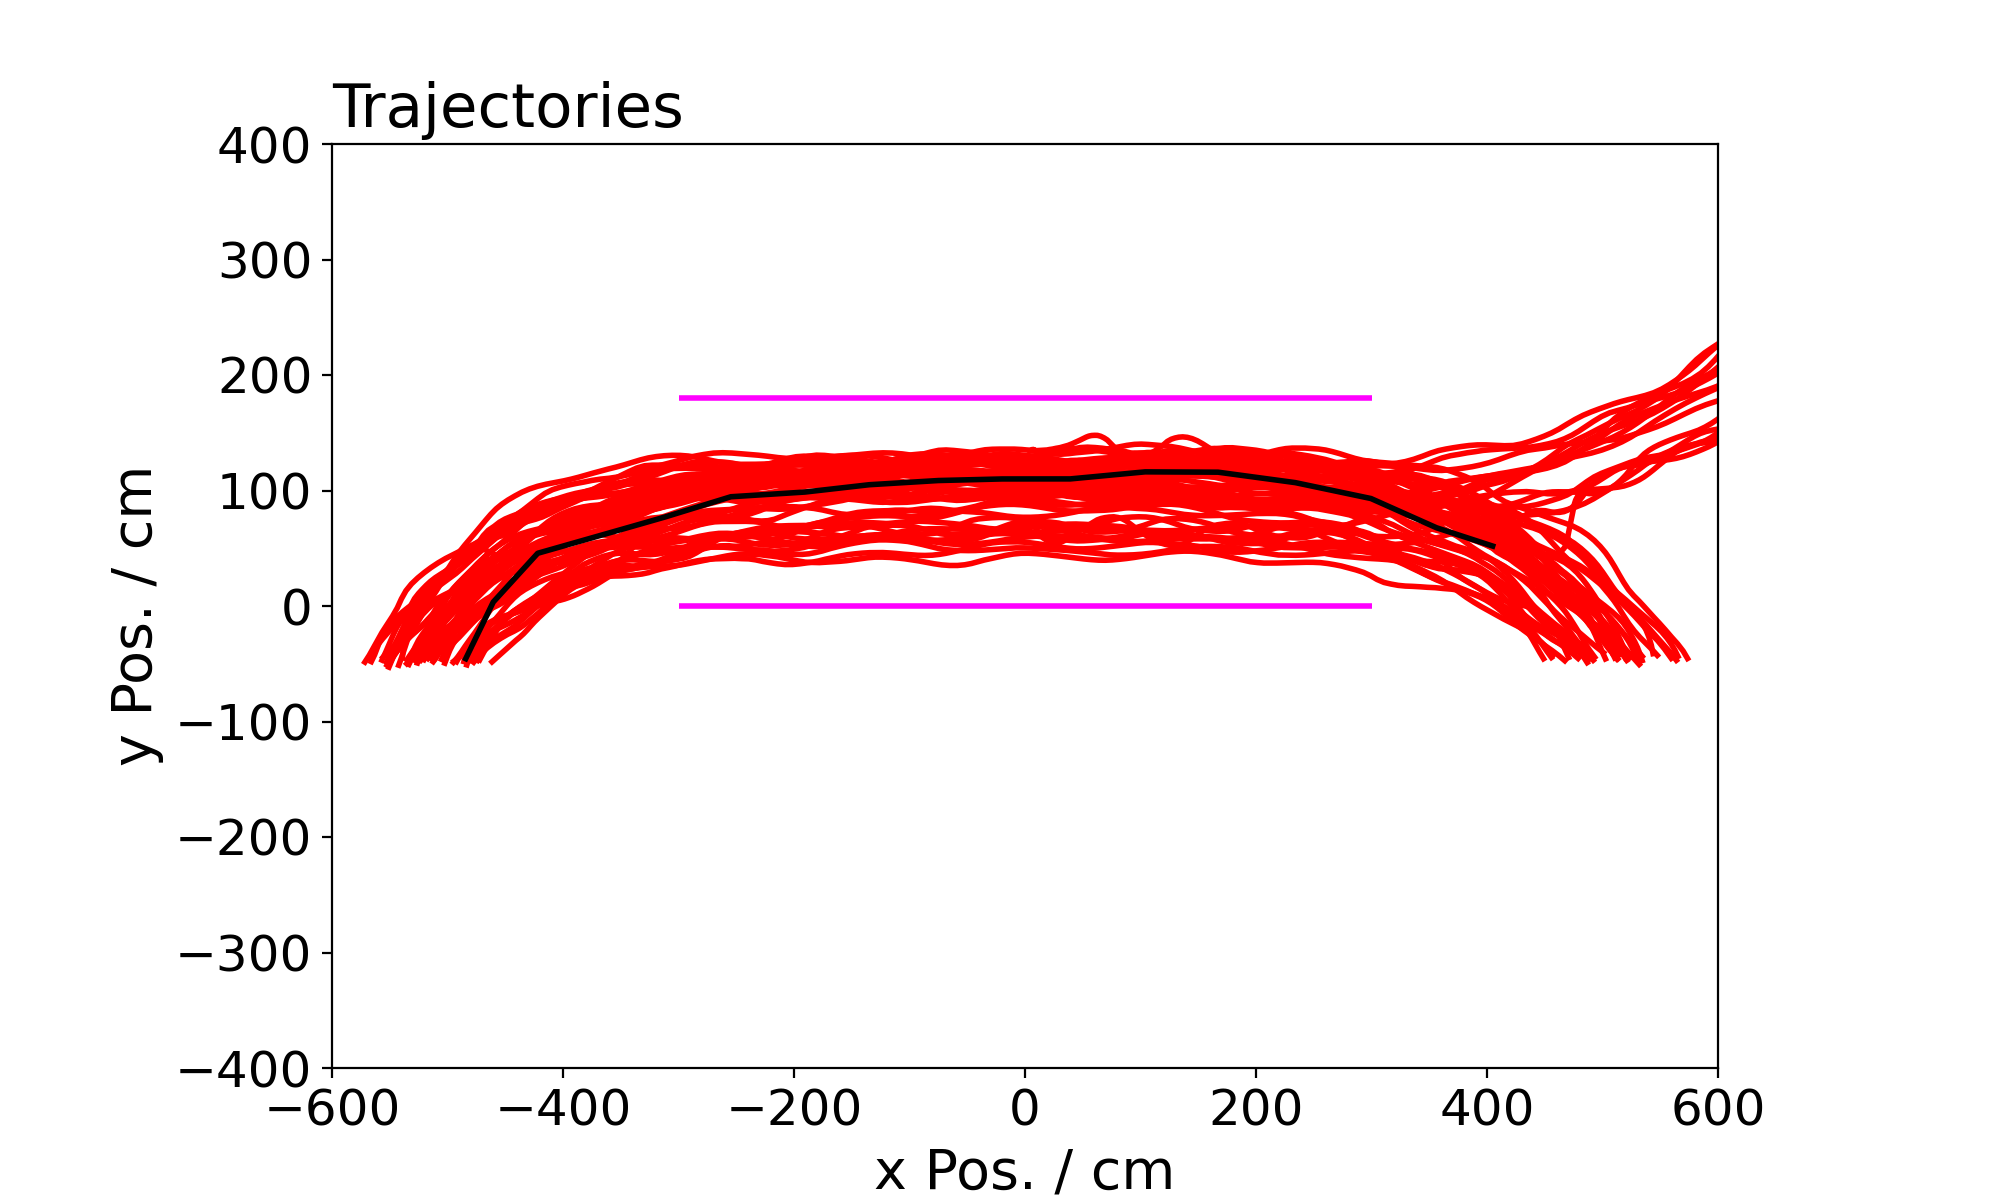

In [91]:

#dp.interpolate_person(1000+test_person)

plotTraj(dp,  boundaries=[-600, 600, -400, 400],
         people=None,
         ai=[ AGENT_OFFSET+test_person],#test_person,
         legend=False, cor=True,
         title="Trajectories",
         path="trajectories.png",
         save=False)

<IPython.core.display.Javascript object>


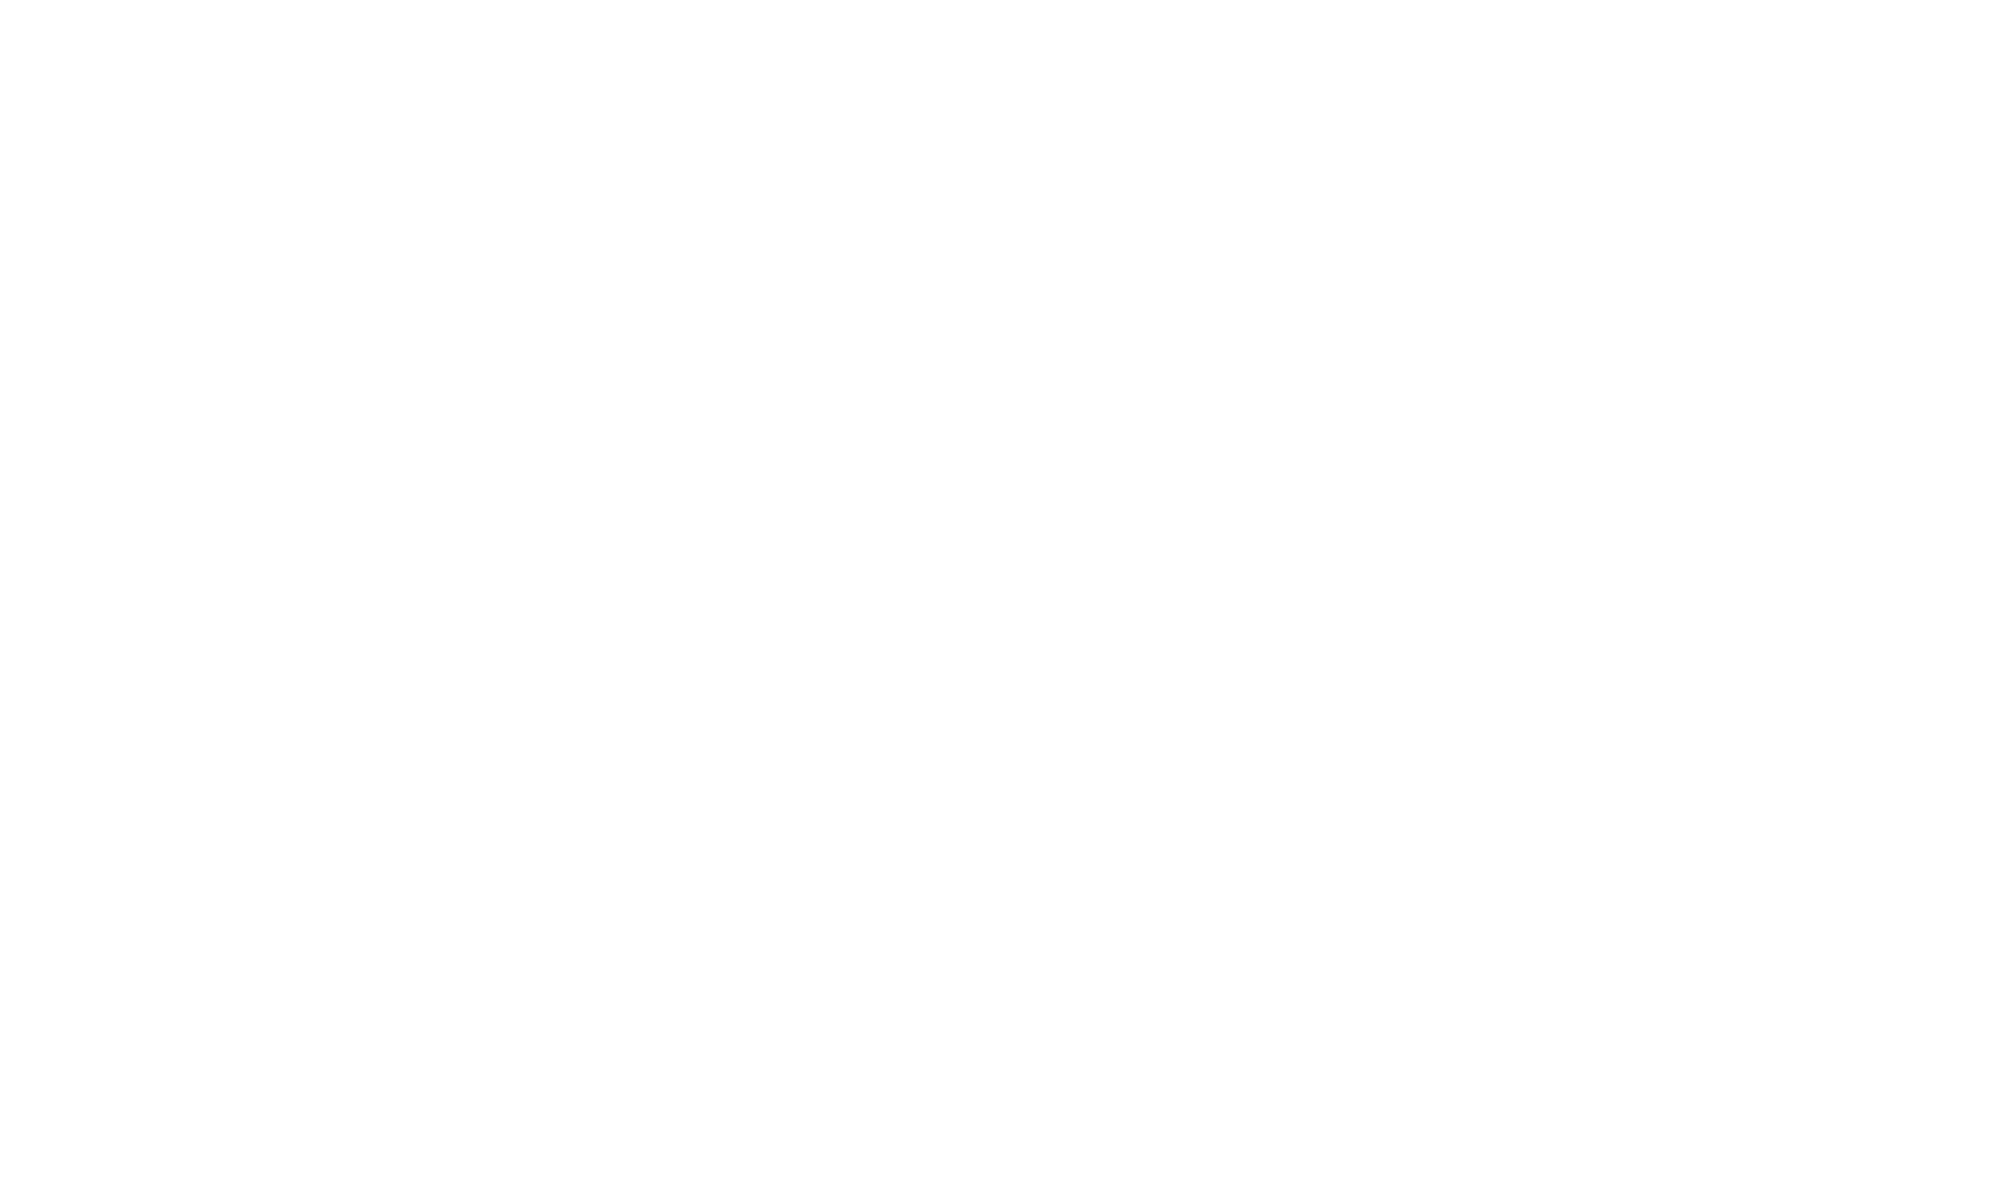

In [92]:
ani = animateLoc(dp, frame_start=frames_o[0], frame_stop=frames_o[-1],ai=[AGENT_OFFSET+test_person],
             boundaries=[-800, 600, -200, 400], step=2, fps=16, 
            title=r"Corridor - {} ".format(param['hidden_s'][0]), save=True,
             path="data/Output/single_agent_all_set_{}.gif".format(param['dataset']['name']), cor=True,
             )
display(ani)

## Multi agent 

People in Dataset:  0
Agents in Dataset:  51
Frame max:  1643
sim from : 0 to 1643


Done! 100% |###################################################| Time:  0:00:09


dataset ready!


<IPython.core.display.Javascript object>


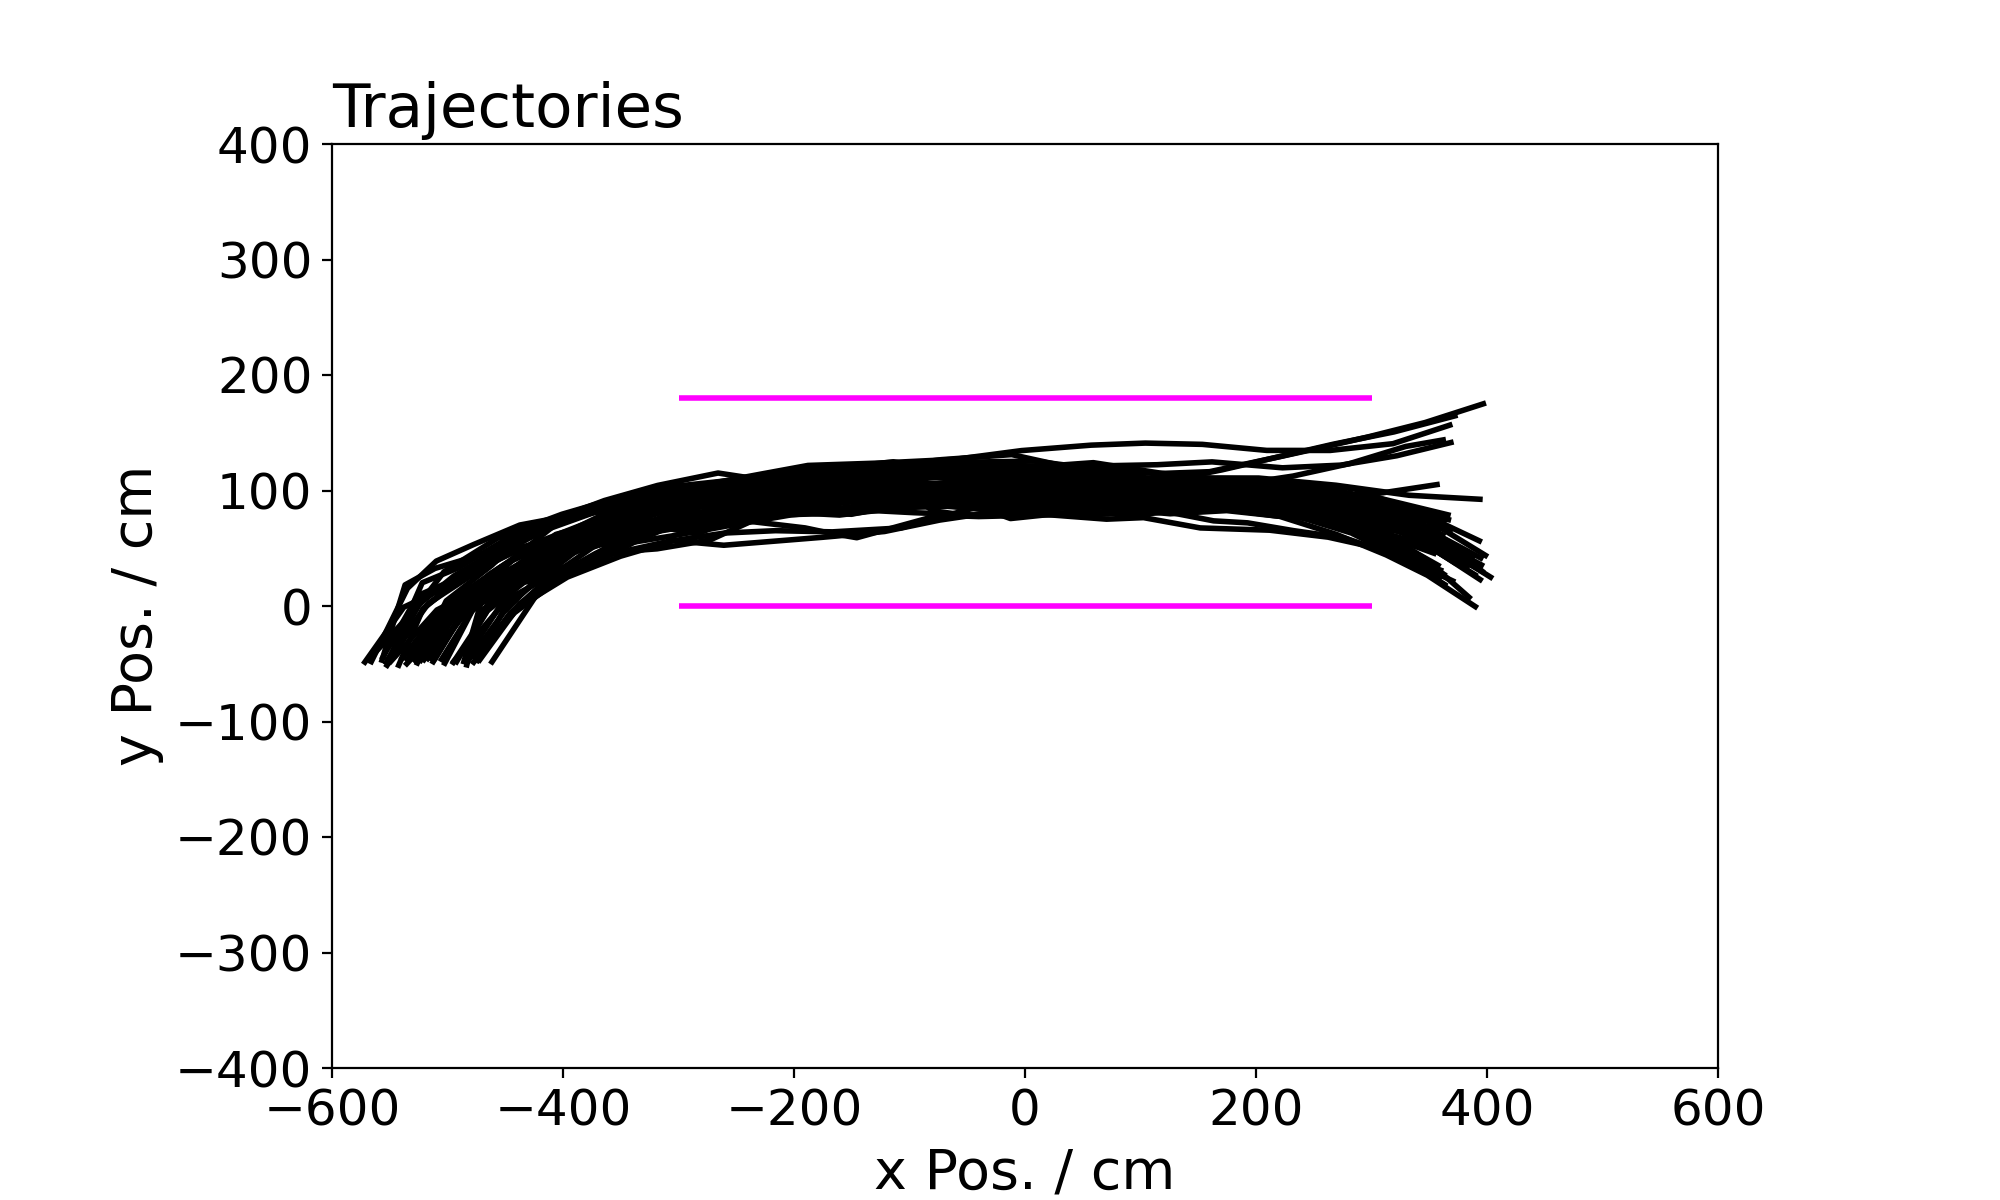

In [83]:
AGENT_OFFSET = 1000

da = DataLoader(None)
da.copy(ds)

# cut the first 250 frames in order to get a more stable time intervall
da.data = da.data[ da.data['f']>250]

#agents_id = np.array([10, 13, 16,  20, 22, 26,  30, 35, 40, ]) 
agents_id = da.data['p'].unique() # replace all person with agents

agents = []

frame_max = 0

for j, test_person in enumerate(agents_id):

    frames_o, pos_vel_o =  da.person( test_person, )
    da.remove_person(test_person)
        
    if len(frames_o)<1:
        continue
    
    frame_max = max(frames_o[-1], frame_max)
    
    agents += [Agent(model,
                     FPS=param['dataset']['fps']/param['dataset']['downsample'],
                     pos_vel_0=pos_vel_o[0],
                     frame_0=int(frames_o[0]/param['dataset']['downsample'])*param['dataset']['downsample'],
                     truth_with_vel=param['dataset']['truth_with_vel'],
                     device=param['device'],
                     id=AGENT_OFFSET+test_person )]



print("People in Dataset: ", da.persons)
print("Agents in Dataset: ", len(agents))
print("Frame max: ", frame_max)

sim = Engine(da,
             agents=agents,
             param=param,
             stop_agent=True,
             xlim=350,
             truth=ds
            )

sim.run(0,frame_max, )


# Dataset for plotting
dp = DataLoader(None)
dp.copy(sim.ds)


# save the results
do = sim.save( include_truth=True )
    
  
print("dataset ready!")

plotTraj(dp,  boundaries=[-600, 600, -400, 400],
         people=None,cor=True,
         ai=agents_id+AGENT_OFFSET,
         legend=False,
         title="Trajectories",
         path="trajectories.png",
         save=False)



In [84]:

dp.data = dp.data.sort_values('f')
animatePreview(dp, boundaries=[-600, 600, -250, 200], step=1)

# Additional functionalities

## Perform measurements

In [81]:


dataset = DataLoader(None)
dataset.copy(do)

roi=((-200, 180),(200, 0))

#15,    30,  60,  85,   95, 110,  140,  230 
#1070, 360, 480, 600,  800, 1000,  600, 250
#.                    500   500 ,  300. 250
m_len = 50
start_f = 500
stop_f = start_f + m_len



dataset.data = dataset.data[ dataset.data['f']>=start_f]
dataset.data = dataset.data[ dataset.data['f']<stop_f]

dataset_p = DataLoader(None)
dataset_a = DataLoader(None)
dataset_p.copy(dataset)
dataset_a.copy(dataset)

dataset_p.data = dataset_p.data[ dataset_p.data['p']<AGENT_OFFSET0]
dataset_a.data = dataset_a.data[ dataset_a.data['p']>=AGENT_OFFSET]





frames_p = dataset_p.data['f'].unique() 
frames_a = dataset_a.data['f'].unique() 

pers_id = dataset_p.data['p'].unique()
agent_id = dataset_a.data['p'].unique()

#print(pers_id, agent_id)

for y in agent_id:
    dataset_a.interpolate_person(y)

density_p = np.zeros_like(frames_p, dtype=np.float )
density_a = np.zeros_like(frames_a, dtype=np.float )

velocity_p = np.zeros_like(pers_id, dtype=np.float)
velocity_a = np.zeros_like(agent_id, dtype=np.float)



for i, f in enumerate(frames_p):
    density_p[i] = get_density(dataset_p, f, roi )
    
for i, f in enumerate(frames_a):
    density_a[i] = get_density(dataset_a, f, roi )

for j, p in enumerate(pers_id):
    velocity_p[j] = get_mean_speed(dataset_p, p, roi=roi, mode="both", normalize=False)

for j, p in enumerate(agent_id):
    velocity_a[j] = get_mean_speed(dataset_a, p, roi=roi, mode="both", normalize=False)

to_m = 100
to_m2 = 100*100


density_pers = density_p.mean() * to_m2
density_pers_err = density_p.std(ddof=1) * to_m2

density_agent = density_a.mean() * to_m2
density_agent_err = density_a.std(ddof=1) * to_m2






velocity_pers = np.nanmean( velocity_p) / to_m
velocity_pers_err = np.nanstd( velocity_p, ddof=1) / to_m

velocity_agent = np.nanmean(velocity_a) / to_m
velocity_agent_err = np.nanstd(velocity_a, ddof=1) / to_m

print("Density Person: ", density_pers, "+/-", density_pers_err)
print("Density Agent: ",density_agent, "+/-", density_agent_err)

print("Velocity Person: ",velocity_pers, "+/-", velocity_pers_err)
print("Velocity Agent: ",velocity_agent, "+/-", velocity_agent_err)



Density Person:  0.14210526315789476 +/- 0.03077200290177613
Density Agent:  0.17236842105263162 +/- 0.05462459055158042
Velocity Person:  1.1457940094965064 +/- 0.08793642143123317
Velocity Agent:  1.1414638462706252 +/- 0.02686174232915928


In [ ]:
output = "data/Output/train_onall_v2/scan_all_agents_trainon_all.npy"

if os.path.isfile(output):
    scan = np.load(output)
    

else:
    scan = np.zeros((len(scan), 8))
    
scan[scan_idx] = [density_pers, density_pers_err, density_agent, density_agent_err,
                  velocity_pers, velocity_pers_err, velocity_agent, velocity_agent_err]
np.save(output, scan)

In [ ]:
ani = animateLoc(dataset_a, frame_start=start_f, frame_stop=stop_f,ai=agents_id+AGENT_OFFSET,
             boundaries=[-600, 500, -200, 300], step=1, fps=16,
             title=r"Corridor - {} - $\varrho$={:.3}".format( param['hidden_s'], density_agent), save=False,
             path="data/Output/train_onall_v2/all_agents_all_set{}.gif".format(param['dataset']['name']), cor=True)

display(ani)

In [ ]:

ani = animateLoc(dataset_p, frame_start=start_f, frame_stop=stop_f,ai=None,
             boundaries=[-600, 500, -200, 300], step=1, fps=16,
             title=r"Corridor - {} - $\varrho$={:.3}".format(param['hidden_s'], density_pers), save=False,
             path="data/Output/train_onall_v2/truth_all_set_{}.gif".format(param['dataset']['name']), cor=True)

display(ani)

<IPython.core.display.Javascript object>


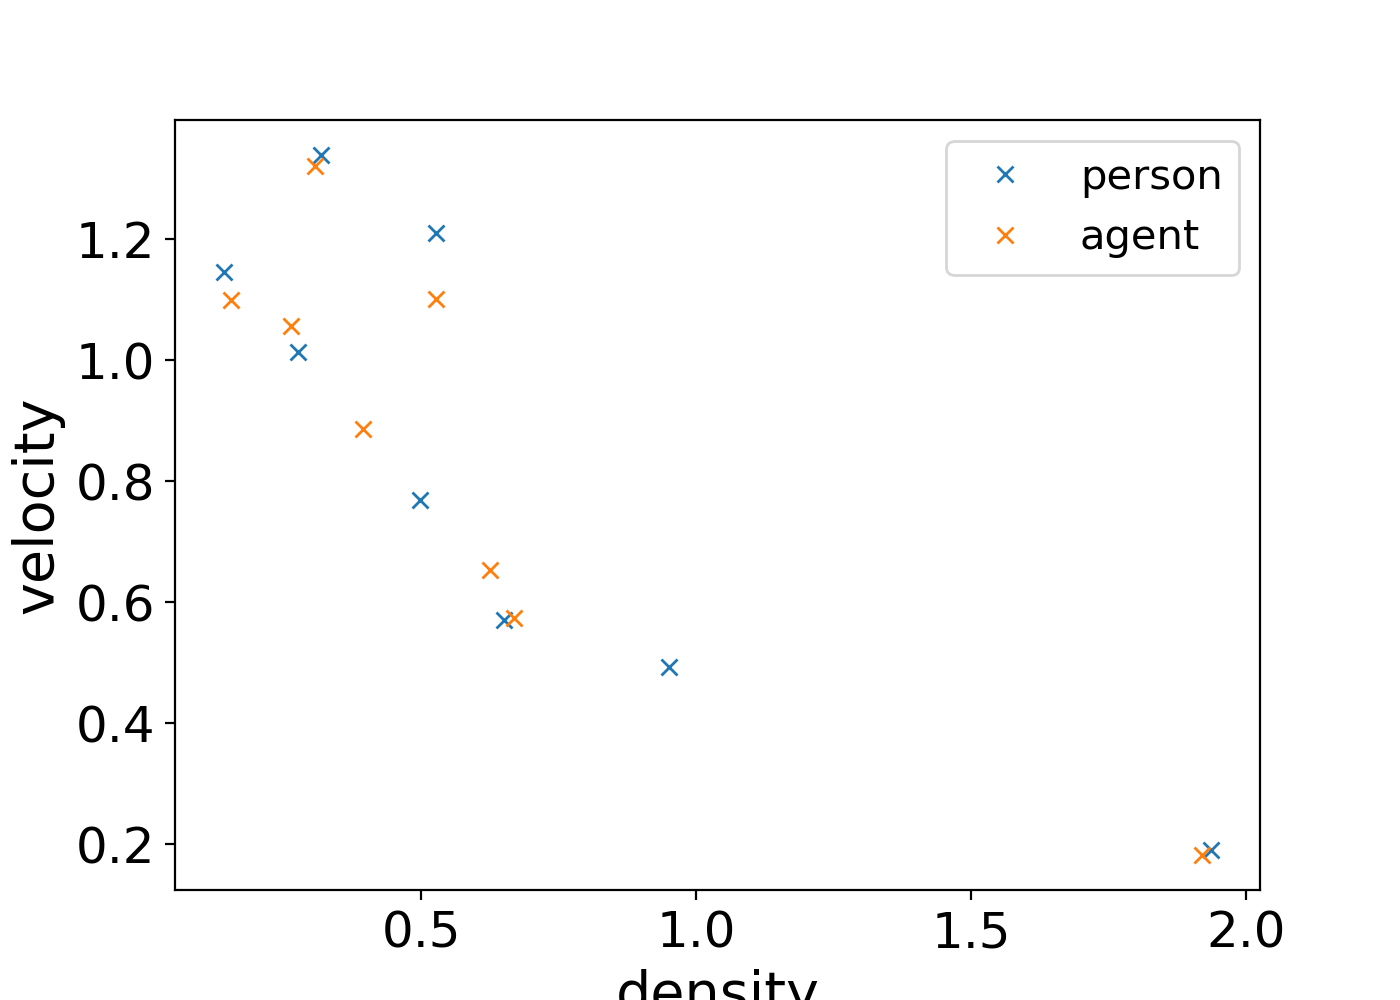

<IPython.core.display.Javascript object>


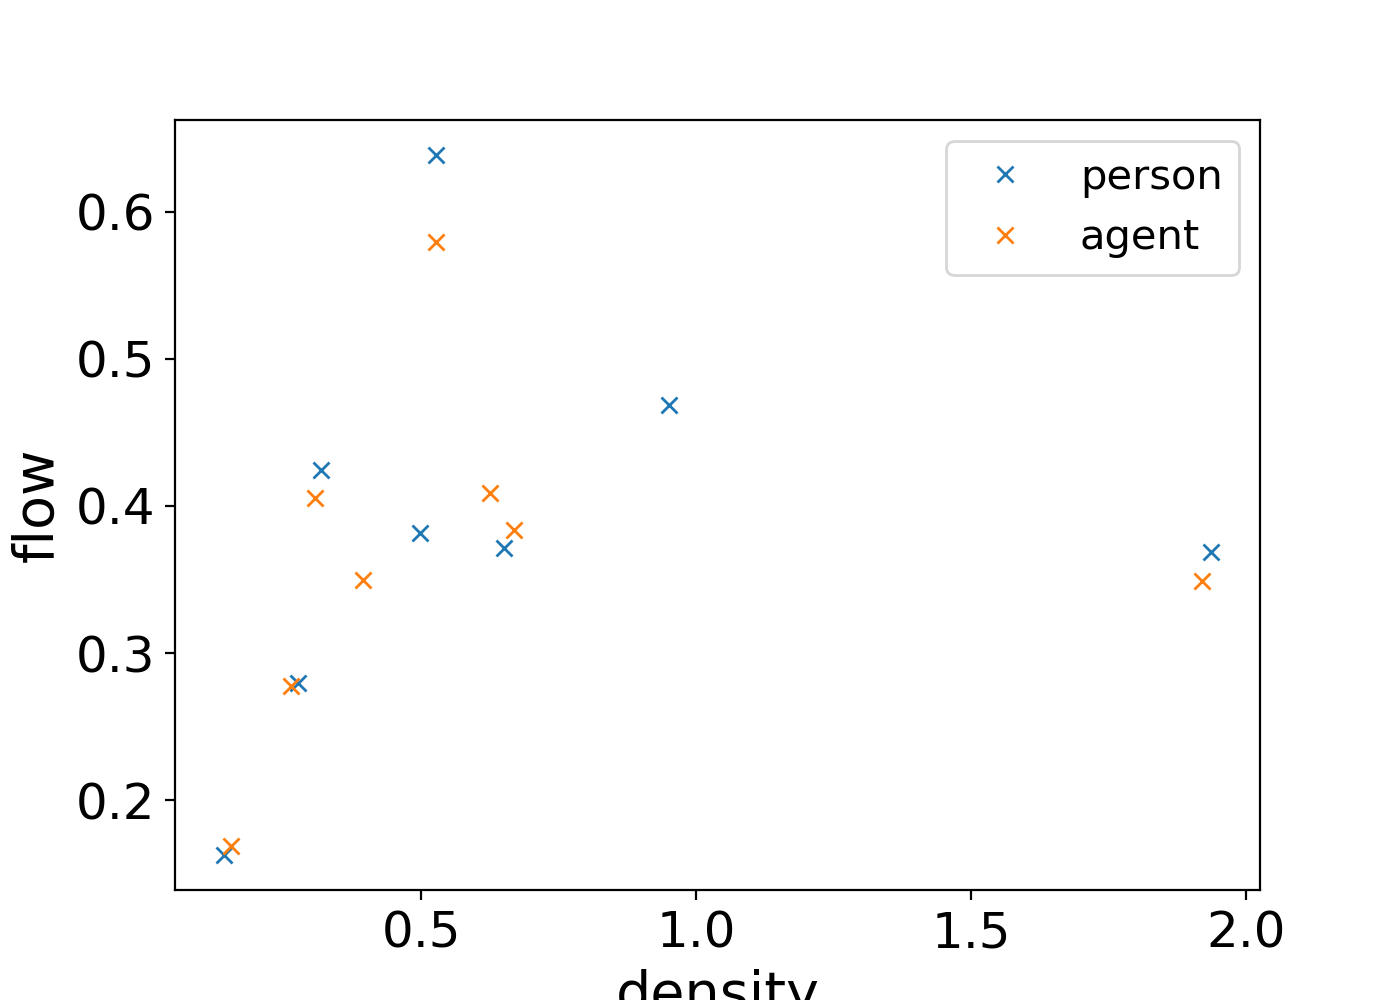

In [269]:
scan = np.load(output)

p_density = scan[:,0]
a_density = scan[:,2]
p_vel = scan[:, 4]
a_vel = scan[:, 6]

plt.figure()
plt.ylabel("velocity")
plt.xlabel("density")
plt.plot(p_density, p_vel, marker="x", ls="", label="person")
plt.plot(a_density, a_vel, marker="x", ls="", label="agent")
plt.legend()
plt.show()

plt.figure()
plt.ylabel("flow")
plt.xlabel("density")
plt.plot(p_density, p_vel*p_density,  marker="x", ls="", label="person")
plt.plot(a_density, a_vel*a_density,  marker="x", ls="", label="agent")
plt.legend()
plt.show()

## Append datasets

In [17]:
# initalize a new appedn buffer

t_i_a = []
t_t_a = []
v_i_a = []
v_t_a = []
te_i_a = []
te_t_a = []


In [39]:
# append the current dataset to the buffer
t_i_a.append(train[0])
t_t_a.append(train[1])
v_i_a.append(val[0])
v_t_a.append(val[1])
te_i_a.append(test[0])
te_t_a.append(test[1])

In [40]:
# Stack buffer of train data to one big array
print(len(t_i_a))

t_i_a_n = np.vstack(t_i_a)
t_t_a_n = np.vstack(t_t_a)

v_i_a_n = np.vstack(v_i_a)
v_t_a_n = np.vstack(v_t_a)

te_i_a_n = np.vstack(te_i_a)
te_t_a_n = np.vstack(te_t_a)

#120826,

8


In [42]:
# reformat data to the desired format
train = (t_i_a_n, t_t_a_n)
val = (v_i_a_n, v_t_a_n)
test = (te_i_a_n, te_t_a_n)

# update the parameter dict
dset['date'] = time.ctime()
dset['creator'] = 'zehndiii'
dset['augmentation'] = str([])
dset['name'] = 'all'
param['dataset'] = dset

# generate the file name
sufix = "_nn{}_s{}_vr{}_m{}_vi{}_st{}_d{}".format(dset['neighbors'],
                                 dset['shuffle'],
                                 dset['truth_with_vel'],
                                 dset['mode'],
                                 dset['ret_vel']+dset['nn_vel'], 
                                 dset['step_nr'],
                                 dset['downsample'])


f_name = PATH2+param['dataset']['name']+sufix+'.h5'

# save the dataset
hd.save_trainingdata(f_name, param, train, val, test)
